# Part 1: Getting Started with Sionna

This tutorial will guide you through Sionna, from its basic principles to the implementation of a point-to-point link with a 5G NR compliant code and a 3GPP channel model.
You will also learn how to write custom trainable layers by implementing a state of the art neural receiver, and how to train and evaluate end-to-end communication systems.

The tutorial is structured in four notebooks:

- **Part I: Getting started with Sionna**

- Part II: Differentiable Communication Systems

- Part III: Advanced Link-level Simulations

- Part IV: Toward Learned Receivers


The [official documentation](https://nvlabs.github.io/sionna) provides key material on how to use Sionna and how its components are implemented.

* [Imports & Basics](#Imports-&-Basics)
* [Sionna Data-flow and Design Paradigms](#Sionna-Data-flow-and-Design-Paradigms)
* [Hello, Sionna!](#Hello,-Sionna!)
* [Communication Systems as Keras Models](#Communication-Systems-as-Keras-Models)
* [Forward Error Correction](#Forward-Error-Correction-(FEC))
* [Eager vs. Graph Mode](#Eager-vs-Graph-Mode)
* [Exercise](#Exercise)

## Imports & Basics

In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# Import TensorFlow and NumPy
import tensorflow as tf
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')
import numpy as np

# For plotting
%matplotlib inline 
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements 
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

We can now access Sionna functions within the `sn` namespace.

**Hint**: In Jupyter notebooks, you can run bash commands with `!`.

In [2]:
!nvidia-smi

Fri Jun 14 21:08:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:99:00.0 Off |                  Off |
| 30%   32C    P2              43W / 450W |    425MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Sionna Data-flow and Design Paradigms

Sionna inherently parallelizes simulations via *batching*, i.e., each element in the batch dimension is simulated independently.

This means the first tensor dimension is always used for *inter-frame* parallelization similar to an outer *for-loop* in Matlab/NumPy simulations, but operations can be operated in parallel.

To keep the dataflow efficient, Sionna follows a few simple design principles:

* Signal-processing components are implemented as an individual [Keras layer](https://keras.io/api/layers/).
* `tf.float32` is used as preferred datatype and `tf.complex64` for complex-valued datatypes, respectively.  
This allows simpler re-use of components (e.g., the same scrambling layer can be used for binary inputs and LLR-values).
* `tf.float64`/`tf.complex128` are available when high precision is needed.
* Models can be developed in *eager mode* allowing simple (and fast) modification of system parameters.
* Number crunching simulations can be executed in the faster *graph mode* or even *XLA* acceleration (experimental) is available for most components.
* Whenever possible, components are automatically differentiable via [auto-grad](https://www.tensorflow.org/guide/autodiff) to simplify the deep learning design-flow.
* Code is structured into sub-packages for different tasks such as channel coding, mapping,... (see [API documentation](http://nvlabs.github.io/sionna/api/sionna.html) for details).

These paradigms simplify the re-useability and reliability of our components for a wide range of communications related applications.

## Hello, Sionna!

Let's start with a very simple simulation: Transmitting QAM symbols over an AWGN channel. We will implement the system shown in the figure below.

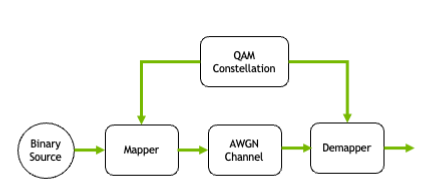

We will use upper case for naming simulation parameters that are used throughout this notebook

Every layer needs to be initialized once before it can be used.

**Tip**: Use the [API documentation](http://nvlabs.github.io/sionna/api/sionna.html) to find an overview of all existing components.
You can directly access the signature and the docstring within jupyter via `Shift+TAB`.

*Remark*: Most layers are defined to be complex-valued.

We first need to create a QAM constellation.

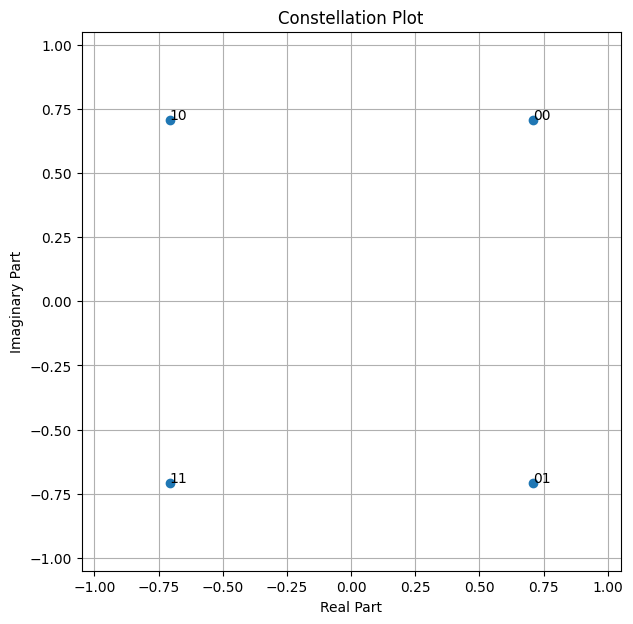

In [3]:
NUM_BITS_PER_SYMBOL = 2 # QPSK
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#创建一个QAM的星座对象
constellation.show();

**Task:** Try to change the modulation order, e.g., to 16-QAM.

We then need to setup a mapper to map bits into constellation points. The mapper takes as parameter the constellation.

We also need to setup a corresponding demapper to compute log-likelihood ratios (LLRs) from received noisy samples.

In [4]:
mapper = sn.mapping.Mapper(constellation=constellation)

# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation) 

**Tip**: You can access the signature+docstring via `?` command and print the complete class definition via `??` operator.

Obviously, you can also access the source code via [https://github.com/nvlabs/sionna/](https://github.com/nvlabs/sionna/).

In [5]:
# print class definition of the Constellation class
sn.mapping.Mapper??

Init signature:
sn.mapping.Mapper(
    constellation_type=None,
    num_bits_per_symbol=None,
    constellation=None,
    return_indices=False,
    dtype=tf.complex64,
    **kwargs,
)
Source:        
class Mapper(Layer):
    # pylint: disable=line-too-long
    r"""
    Mapper(constellation_type=None, num_bits_per_symbol=None, constellation=None, return_indices=False, dtype=tf.complex64, **kwargs)

    Maps binary tensors to points of a constellation.

    This class defines a layer that maps a tensor of binary values
    to a tensor of points from a provided constellation.

    Parameters
    ----------
    constellation_type : One of ["qam", "pam", "custom"], str
        For "custom", an instance of :class:`~sionna.mapping.Constellation`
        must be provided.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.
        Only required for ``constellation_type`` in ["qam", "pam"].

    constellation :  Constellation
        An instanc

As can be seen, the `Mapper` class inherits from `Layer`, i.e., implements a Keras layer.

This allows to simply built complex systems by using the [Keras functional API](https://keras.io/guides/functional_api/) to stack layers.

Sionna provides as utility a binary source to sample uniform i.i.d. bits.

In [6]:
binary_source = sn.utils.BinarySource()

Finally, we need the AWGN channel.

In [7]:
awgn_channel = sn.channel.AWGN()

Sionna provides a utility function to compute the noise power spectral density ratio $N_0$ from the energy per bit to noise power spectral density ratio $E_b/N_0$ in dB and a variety of parameters such as the coderate and the nunber of bits per symbol.

In [8]:
no = sn.utils.ebnodb2no(ebno_db=10.0,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0) # Coderate set to 1 as we do uncoded transmission here

We now have all the components we need to transmit QAM symbols over an AWGN channel.

Sionna natively supports multi-dimensional tensors.

Most layers operate at the last dimension and can have arbitrary input shapes (preserved at output).

In [9]:
BATCH_SIZE = 64 # How many examples are processed by Sionna in parallel

bits = binary_source([BATCH_SIZE,
                      1024]) # Blocklength
print("Shape of bits: ", bits.shape)

x = mapper(bits)
print("Shape of x: ", x.shape)

y = awgn_channel([x, no])
print("Shape of y: ", y.shape)

llr = demapper([y, no])
print("Shape of llr: ", llr.shape)

Shape of bits:  (64, 1024)
Shape of x:  (64, 512)
Shape of y:  (64, 512)
Shape of llr:  (64, 1024)


In *Eager* mode, we can directly access the values of each tensor. This simplify debugging.

In [10]:
num_samples = 8 # how many samples shall be printed
num_symbols = int(num_samples/NUM_BITS_PER_SYMBOL)

print(f"First {num_samples} transmitted bits: {bits[0,:num_samples]}")
print(f"First {num_symbols} transmitted symbols: {np.round(x[0,:num_symbols], 2)}")
print(f"First {num_symbols} received symbols: {np.round(y[0,:num_symbols], 2)}")
print(f"First {num_samples} demapped llrs: {np.round(llr[0,:num_samples], 2)}")

First 8 transmitted bits: [1. 0. 1. 0. 0. 0. 1. 1.]
First 4 transmitted symbols: [-0.71+0.71j -0.71+0.71j  0.71+0.71j -0.71-0.71j]
First 4 received symbols: [-0.54+0.89j -0.75+0.87j  0.68+0.6j  -0.78-0.44j]
First 8 demapped llrs: [ 30.76 -50.09  42.41 -49.48 -38.58 -33.75  43.98  24.83]


Let's visualize the received noisy samples.

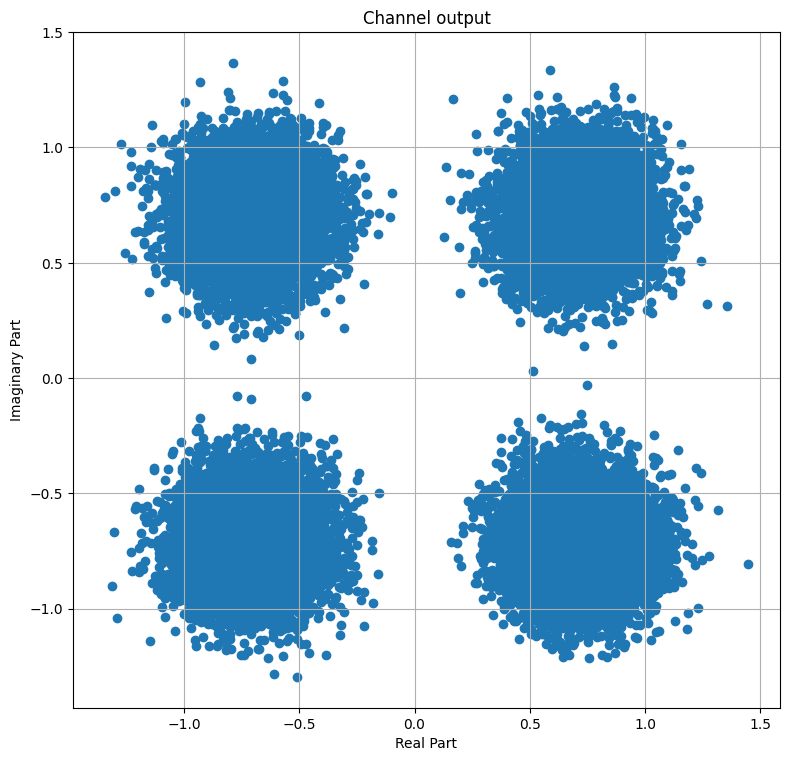

In [11]:
plt.figure(figsize=(8,8))
plt.axes().set_aspect(1)
plt.grid(True)
plt.title('Channel output')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.scatter(tf.math.real(y), tf.math.imag(y))
plt.tight_layout()

**Task:** One can play with the SNR to visualize the impact on the received samples.

**Advanced Task:** Compare the LLR distribution for "app" demapping with "maxlog" demapping.
The [Bit-Interleaved Coded Modulation](https://nvlabs.github.io/sionna/examples/Bit_Interleaved_Coded_Modulation.html) example notebook can be helpful for this task.


## Communication Systems as Keras Models

It is typically more convenient to wrap a Sionna-based communication system into a [Keras models](https://keras.io/api/models/model/).

These models can be simply built by using the [Keras functional API](https://keras.io/guides/functional_api/) to stack layers.

The following cell implements the previous system as a Keras model.

The key functions that need to be defined are `__init__()`, which instantiates the required components, and `__call()__`, which performs forward pass through the end-to-end system.

In [12]:
class UncodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, block_length):
        """
        A keras model of an uncoded transmission over the AWGN channel.

        Parameters
        ----------
        num_bits_per_symbol: int
            The number of bits per constellation symbol, e.g., 4 for QAM16.

        block_length: int
            The number of bits per transmitted message block (will be the codeword length later).

        Input
        -----
        batch_size: int
            The batch_size of the Monte-Carlo simulation.

        ebno_db: float
            The `Eb/No` value (=rate-adjusted SNR) in dB.

        Output
        ------
        (bits, llr):
            Tuple:

        bits: tf.float32
            A tensor of shape `[batch_size, block_length] of 0s and 1s
            containing the transmitted information bits.

        llr: tf.float32
            A tensor of shape `[batch_size, block_length] containing the
            received log-likelihood-ratio (LLR) values.
        """

        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.block_length = block_length
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

    # @tf.function # Enable graph execution to speed things up
    def __call__(self, batch_size, ebno_db):

        # no channel coding used; we set coderate=1.0
        no = sn.utils.ebnodb2no(ebno_db,
                                num_bits_per_symbol=self.num_bits_per_symbol,
                                coderate=1.0)

        bits = self.binary_source([batch_size, self.block_length]) # Blocklength set to 1024 bits
        x = self.mapper(bits)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        return bits, llr

We need first to instantiate the model.

In [13]:
model_uncoded_awgn = UncodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL, block_length=1024)

Sionna provides a utility to easily compute and plot the bit error rate (BER).

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 1.5859e-01 | 1.0000e+00 |      324783 |     2048000 |         2000 |        2000 |         0.2 |reached target block errors
   -2.579 | 1.4676e-01 | 1.0000e+00 |      300573 |     2048000 |         2000 |        2000 |         0.1 |reached target block errors
   -2.158 | 1.3457e-01 | 1.0000e+00 |      275601 |     2048000 |         2000 |        2000 |         0.1 |reached target block errors
   -1.737 | 1.2365e-01 | 1.0000e+00 |      253227 |     2048000 |         2000 |        2000 |         0.1 |reached target block errors
   -1.316 | 1.1174e-01 | 1.0000e+00 |      228846 |     2048000 |         2000 |        2000 |         0.1 |reached target block errors
   -0.895 | 1.0088e-01 | 1.0000e+00 |      206611 |     2048000 |

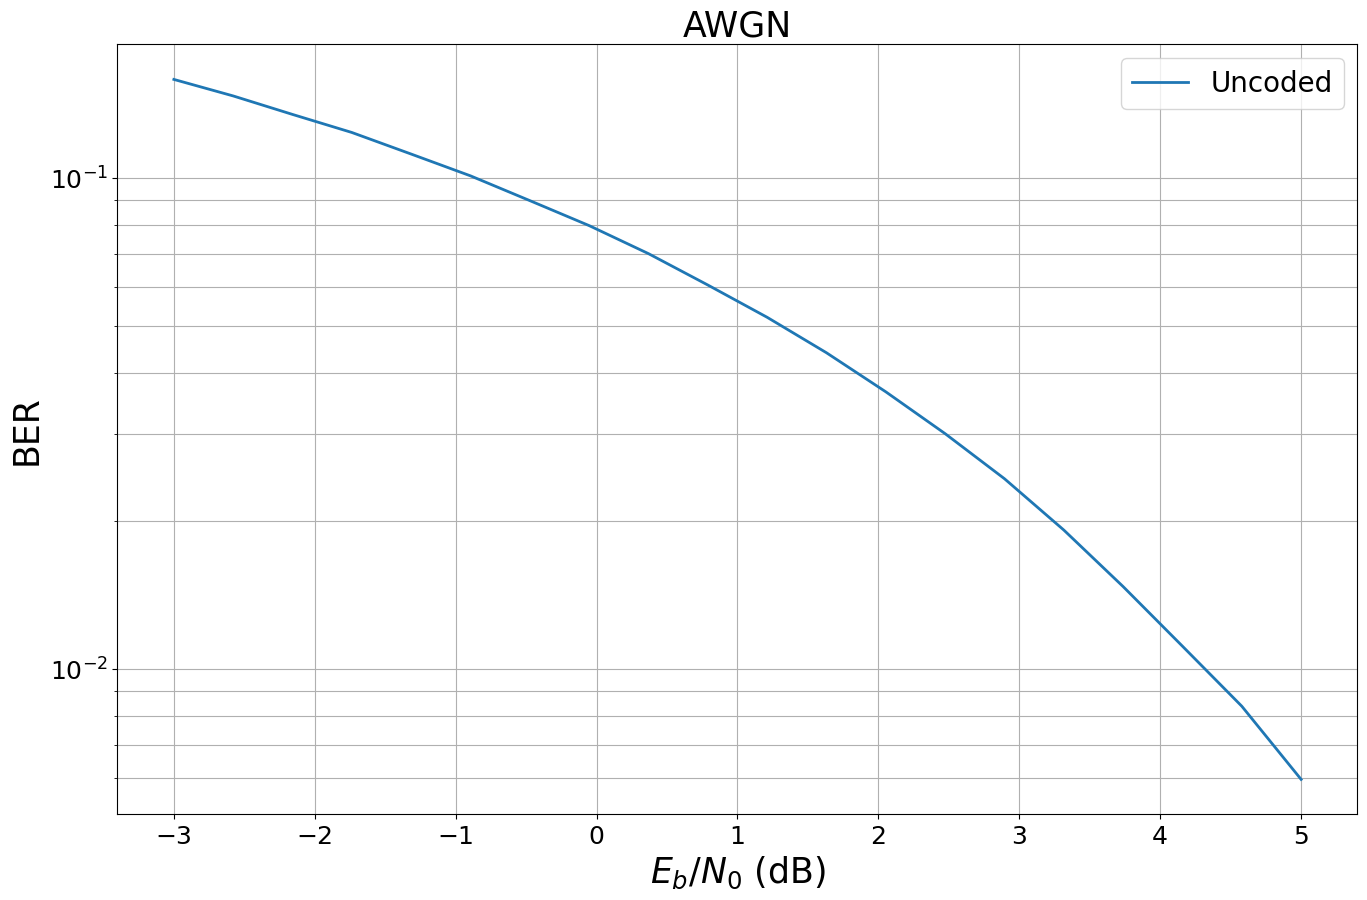

In [14]:
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 5.0 # Maximum value of Eb/N0 [dB] for simulations
BATCH_SIZE = 2000 # How many examples are processed by Sionna in parallel

ber_plots = sn.utils.PlotBER("AWGN")
ber_plots.simulate(model_uncoded_awgn,
                  ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 20),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=100, # simulate until 100 block errors occured
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=True);

The `sn.utils.PlotBER` object stores the results and allows to add additional simulations to the previous curves.

*Remark*: In Sionna, a block error is defined to happen if for two tensors at least one position in the last dimension differs (i.e., at least one bit wrongly received per codeword).
The bit error rate the total number of erroneous positions divided by the total number of transmitted bits.

## Forward Error Correction (FEC)

We now add channel coding to our transceiver to make it more robust against transmission errors. For this, we will use [5G compliant low-density parity-check (LDPC) codes and Polar codes](https://portal.3gpp.org/desktopmodules/Specifications/SpecificationDetails.aspx?specificationId=3214).
You can find more detailed information in the notebooks [Bit-Interleaved Coded Modulation (BICM)](https://nvlabs.github.io/sionna/examples/Bit_Interleaved_Coded_Modulation.html) and [5G Channel Coding and Rate-Matching: Polar vs. LDPC Codes](https://nvlabs.github.io/sionna/examples/5G_Channel_Coding_Polar_vs_LDPC_Codes.html).

In [15]:
k = 12
n = 20

encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder, hard_out=True)

Let us encode some random input bits.

In [16]:
BATCH_SIZE = 1 # one codeword in parallel
u = binary_source([BATCH_SIZE, k])
print("Input bits are: \n", u.numpy())

c = encoder(u)
print("Encoded bits are: \n", c.numpy())

Input bits are: 
 [[0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]]
Encoded bits are: 
 [[1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0.]]


One of the fundamental paradigms of Sionna is batch-processing.
Thus, the example above could be executed with for arbitrary batch-sizes to simulate `batch_size` codewords in parallel.

However, Sionna can do more - it supports *N*-dimensional input tensors and, thereby, allows the processing of multiple samples of multiple users and several antennas in a single command line.
Let's say we want to encoded `batch_size` codewords of length `n` for each of the `num_users` connected to each of the `num_basestations`. 
This means in total we transmit `batch_size` * `n` * `num_users` * `num_basestations` bits.

In [17]:
BATCH_SIZE = 10 # samples per scenario
num_basestations = 4 
num_users = 5 # users per basestation
n = 1000 # codeword length per transmitted codeword
coderate = 0.5 # coderate

k = int(coderate * n) # number of info bits per codeword

# instantiate a new encoder for codewords of length n
encoder = sn.fec.ldpc.LDPC5GEncoder(k, n)

# the decoder must be linked to the encoder (to know the exact code parameters used for encoding)
decoder = sn.fec.ldpc.LDPC5GDecoder(encoder,
                                    hard_out=True, # binary output or provide soft-estimates
                                    return_infobits=True, # or also return (decoded) parity bits
                                    num_iter=20, # number of decoding iterations
                                    cn_type="boxplus-phi") # also try "minsum" decoding

# draw random bits to encode
u = binary_source([BATCH_SIZE, num_basestations, num_users, k])
print("Shape of u: ", u.shape)

# We can immediately encode u for all users, basetation and samples 
# This all happens with a single line of code
c = encoder(u)
print("Shape of c: ", c.shape)

print("Total number of processed bits: ", np.prod(c.shape))

Shape of u:  (10, 4, 5, 500)
Shape of c:  (10, 4, 5, 1000)
Total number of processed bits:  200000


This works for arbitrary dimensions and allows a simple extension of the designed system to multi-user or multi-antenna scenarios.

Let us now replace the LDPC code by a Polar code. The API remains similar.

In [18]:
k = 64
n = 128

encoder = sn.fec.polar.Polar5GEncoder(k, n)
decoder = sn.fec.polar.Polar5GDecoder(encoder,
                                      dec_type="SCL") # you can also use "SCL" 

*Advanced Remark:* The 5G Polar encoder/decoder class directly applies rate-matching and the additional CRC concatenation. 
This is all done internally and transparent to the user.

In case you want to access low-level features of the Polar codes, please use `sionna.fec.polar.PolarEncoder` and the desired decoder (`sionna.fec.polar.PolarSCDecoder`, `sionna.fec.polar.PolarSCLDecoder` or `sionna.fec.polar.PolarBPDecoder`).

Further details can be found in the tutorial notebook on [5G Channel Coding and Rate-Matching: Polar vs. LDPC Codes](https://nvlabs.github.io/sionna/examples/5G_Channel_Coding_Polar_vs_LDPC_Codes.html).


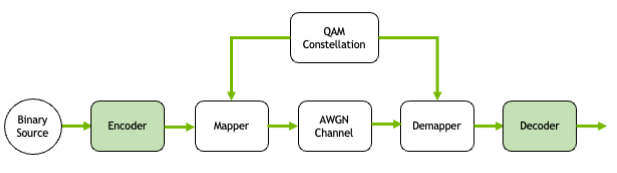

In [19]:
class CodedSystemAWGN(Model): # Inherits from Keras Model
    def __init__(self, num_bits_per_symbol, n, coderate):
        super().__init__() # Must call the Keras model initializer

        self.num_bits_per_symbol = num_bits_per_symbol
        self.n = n
        self.k = int(n*coderate)
        self.coderate = coderate
        self.constellation = sn.mapping.Constellation("qam", self.num_bits_per_symbol)
       
        self.mapper = sn.mapping.Mapper(constellation=self.constellation)
        self.demapper = sn.mapping.Demapper("app", constellation=self.constellation)
        
        self.binary_source = sn.utils.BinarySource()
        self.awgn_channel = sn.channel.AWGN()

        self.encoder = sn.fec.ldpc.LDPC5GEncoder(self.k, self.n)
        self.decoder = sn.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)
    
    #@tf.function # activate graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sn.utils.ebnodb2no(ebno_db, num_bits_per_symbol=self.num_bits_per_symbol, coderate=self.coderate)

        bits = self.binary_source([batch_size, self.k])
        codewords = self.encoder(bits)
        x = self.mapper(codewords)
        y = self.awgn_channel([x, no])
        llr = self.demapper([y,no])
        bits_hat = self.decoder(llr)
        return bits, bits_hat

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 2.7976e-01 | 1.0000e+00 |      572950 |     2048000 |         2000 |        2000 |         6.5 |reached target block errors
   -2.429 | 2.6378e-01 | 1.0000e+00 |      540212 |     2048000 |         2000 |        2000 |         2.9 |reached target block errors
   -1.857 | 2.4632e-01 | 1.0000e+00 |      504464 |     2048000 |         2000 |        2000 |         2.8 |reached target block errors
   -1.286 | 2.2700e-01 | 1.0000e+00 |      464887 |     2048000 |         2000 |        2000 |         2.8 |reached target block errors
   -0.714 | 2.0318e-01 | 1.0000e+00 |      416111 |     2048000 |         2000 |        2000 |         2.2 |reached target block errors
   -0.143 | 1.7191e-01 | 1.0000e+00 |      352077 |     2048000 |

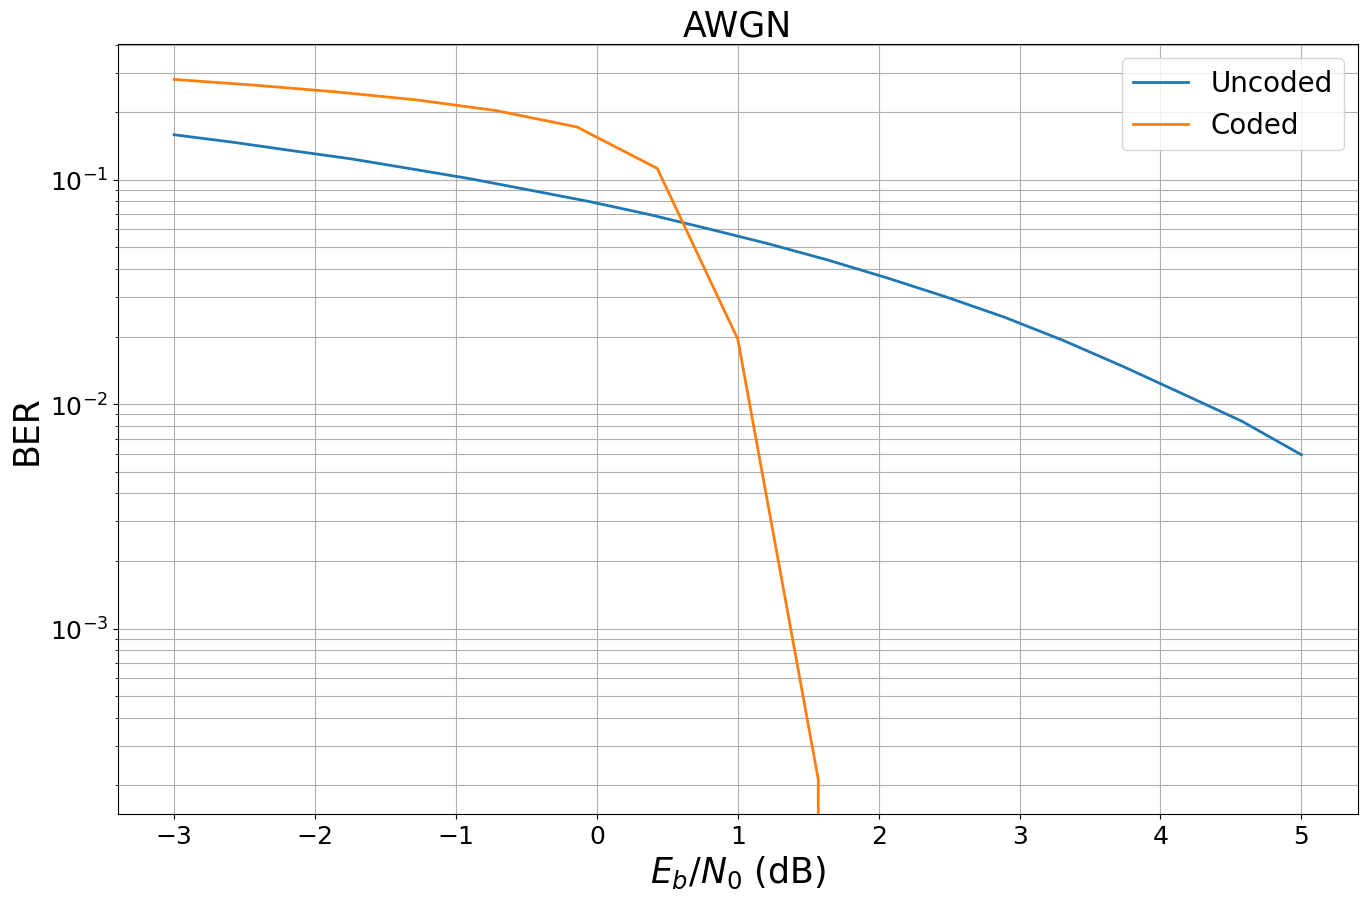

In [20]:
CODERATE = 0.5
BATCH_SIZE = 2000

model_coded_awgn = CodedSystemAWGN(num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                                   n=2048,
                                   coderate=CODERATE)
ber_plots.simulate(model_coded_awgn,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 15),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=500,
                   legend="Coded",
                   soft_estimates=False,
                   max_mc_iter=15,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

As can be seen, the `BerPlot` class uses multiple stopping conditions and stops the simulation after no error occured at a specifc SNR point.

**Task**: Replace the coding scheme by a Polar encoder/decoder or a convolutional code with Viterbi decoding.

## Eager vs Graph Mode

So far, we have executed the example in *eager* mode. 
This allows to run TensorFlow ops as if it was written NumPy and simplifies development and debugging.

However, to unleash Sionna's full performance, we need to activate *graph* mode which can be enabled with the function decorator *@tf.function()*.

We refer to [TensorFlow Functions](https://www.tensorflow.org/guide/function) for further details.


In [21]:
@tf.function() # enables graph-mode of the following function
def run_graph(batch_size, ebno_db):
    # all code inside this function will be executed in graph mode, also calls of other functions
    print(f"Tracing run_graph for values batch_size={batch_size} and ebno_db={ebno_db}.") # print whenever this function is traced
    return model_coded_awgn(batch_size, ebno_db)
    

In [22]:
batch_size = 10 # try also different batch sizes
ebno_db = 1.5

# run twice - how does the output change?
run_graph(batch_size, ebno_db)

Tracing run_graph for values batch_size=10 and ebno_db=1.5.


(<tf.Tensor: shape=(10, 1024), dtype=float32, numpy=
 array([[1., 0., 0., ..., 1., 1., 0.],
        [1., 1., 0., ..., 1., 1., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        ...,
        [1., 0., 1., ..., 1., 1., 1.],
        [1., 0., 1., ..., 0., 1., 0.],
        [0., 1., 0., ..., 1., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(10, 1024), dtype=float32, numpy=
 array([[1., 0., 0., ..., 1., 1., 0.],
        [1., 1., 0., ..., 1., 1., 0.],
        [0., 1., 0., ..., 1., 0., 0.],
        ...,
        [1., 0., 1., ..., 1., 1., 1.],
        [1., 0., 1., ..., 0., 1., 0.],
        [0., 1., 0., ..., 1., 0., 0.]], dtype=float32)>)

In graph mode, Python code (i.e., *non-TensorFlow code*) is only executed whenever the function is *traced*.
This happens whenever the input signature changes.

As can be seen above, the print statement was executed, i.e., the graph was traced again.

To avoid this re-tracing for different inputs, we now input tensors.
You can see that the function is now traced once for input tensors of same dtype.

See [TensorFlow Rules of Tracing](https://www.tensorflow.org/guide/function#rules_of_tracing) for details.

**Task:** change the code above such that tensors are used as input and execute the code with different input values. Understand when re-tracing happens.

*Remark*: if the input to a function is a tensor its signature must change and not *just* its value. For example the input could have a different size or datatype.
For efficient code execution, we usually want to avoid re-tracing of the code if not required.

In [23]:
# You can print the cached signatures with
print(run_graph.pretty_printed_concrete_signatures())

Input Parameters:
  batch_size (POSITIONAL_OR_KEYWORD): Literal[10]
  ebno_db (POSITIONAL_OR_KEYWORD): Literal[1.5]
Output Type:
  Tuple[TensorSpec(shape=(10, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(10, 1024), dtype=tf.float32, name=None)]
Captures:
  140563441422352: TensorSpec(shape=(416, 8), dtype=tf.int32, name=None)
  140563441427728: TensorSpec(shape=(416, 6), dtype=tf.int32, name=None)
  140563441427920: TensorSpec(shape=(3952, 4), dtype=tf.int32, name=None)
  140563441428112: TensorSpec(shape=(3952, 2), dtype=tf.int32, name=None)
  140563441426768: TensorSpec(shape=(2,), dtype=tf.int32, name=None)
  140563441432720: TensorSpec(shape=(2, 4), dtype=tf.float32, name=None)
  140563441425232: TensorSpec(shape=(), dtype=tf.float32, name=None)
  140563441423312: TensorSpec(shape=(2, 2), dtype=tf.int32, name=None)
  140563441425616: TensorSpec(shape=(2, 2), dtype=tf.int32, name=None)
  140563441427152: TensorSpec(shape=(), dtype=tf.float32, name=None)
  140563441428304: 

We now compare the throughput of the different modes.

In [24]:
repetitions = 4 # average over multiple runs
batch_size = BATCH_SIZE # try also different batch sizes
ebno_db = 1.5

# --- eager mode ---
t_start = time.perf_counter()
for _ in range(repetitions):
    bits, bits_hat = model_coded_awgn(tf.constant(batch_size, tf.int32),
                                tf.constant(ebno_db, tf. float32))
t_stop = time.perf_counter()
# throughput in bit/s
throughput_eager = np.size(bits.numpy())*repetitions / (t_stop - t_start) / 1e6

print(f"Throughput in Eager mode: {throughput_eager :.3f} Mbit/s")
# --- graph mode ---
# run once to trace graph (ignored for throughput)
run_graph(tf.constant(batch_size, tf.int32),
          tf.constant(ebno_db, tf. float32))

t_start = time.perf_counter()
for _ in range(repetitions):
    bits, bits_hat = run_graph(tf.constant(batch_size, tf.int32),
                                tf.constant(ebno_db, tf. float32))
t_stop = time.perf_counter()
# throughput in bit/s
throughput_graph = np.size(bits.numpy())*repetitions / (t_stop - t_start) / 1e6

print(f"Throughput in graph mode: {throughput_graph :.3f} Mbit/s")



Throughput in Eager mode: 0.664 Mbit/s
Tracing run_graph for values batch_size=Tensor("batch_size:0", shape=(), dtype=int32) and ebno_db=Tensor("ebno_db:0", shape=(), dtype=float32).
Throughput in graph mode: 14.183 Mbit/s


Let's run the same simulation as above in graph mode.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -3.0 | 2.7965e-01 | 1.0000e+00 |      572728 |     2048000 |         2000 |        2000 |         0.2 |reached target block errors
   -2.273 | 2.5912e-01 | 1.0000e+00 |      530683 |     2048000 |         2000 |        2000 |         0.2 |reached target block errors
   -1.545 | 2.3609e-01 | 1.0000e+00 |      483520 |     2048000 |         2000 |        2000 |         0.2 |reached target block errors
   -0.818 | 2.0829e-01 | 1.0000e+00 |      426585 |     2048000 |         2000 |        2000 |         0.2 |reached target block errors
   -0.091 | 1.6775e-01 | 1.0000e+00 |      343560 |     2048000 |         2000 |        2000 |         0.2 |reached target block errors
    0.636 | 7.7485e-02 | 9.1900e-01 |      158689 |     2048000 |

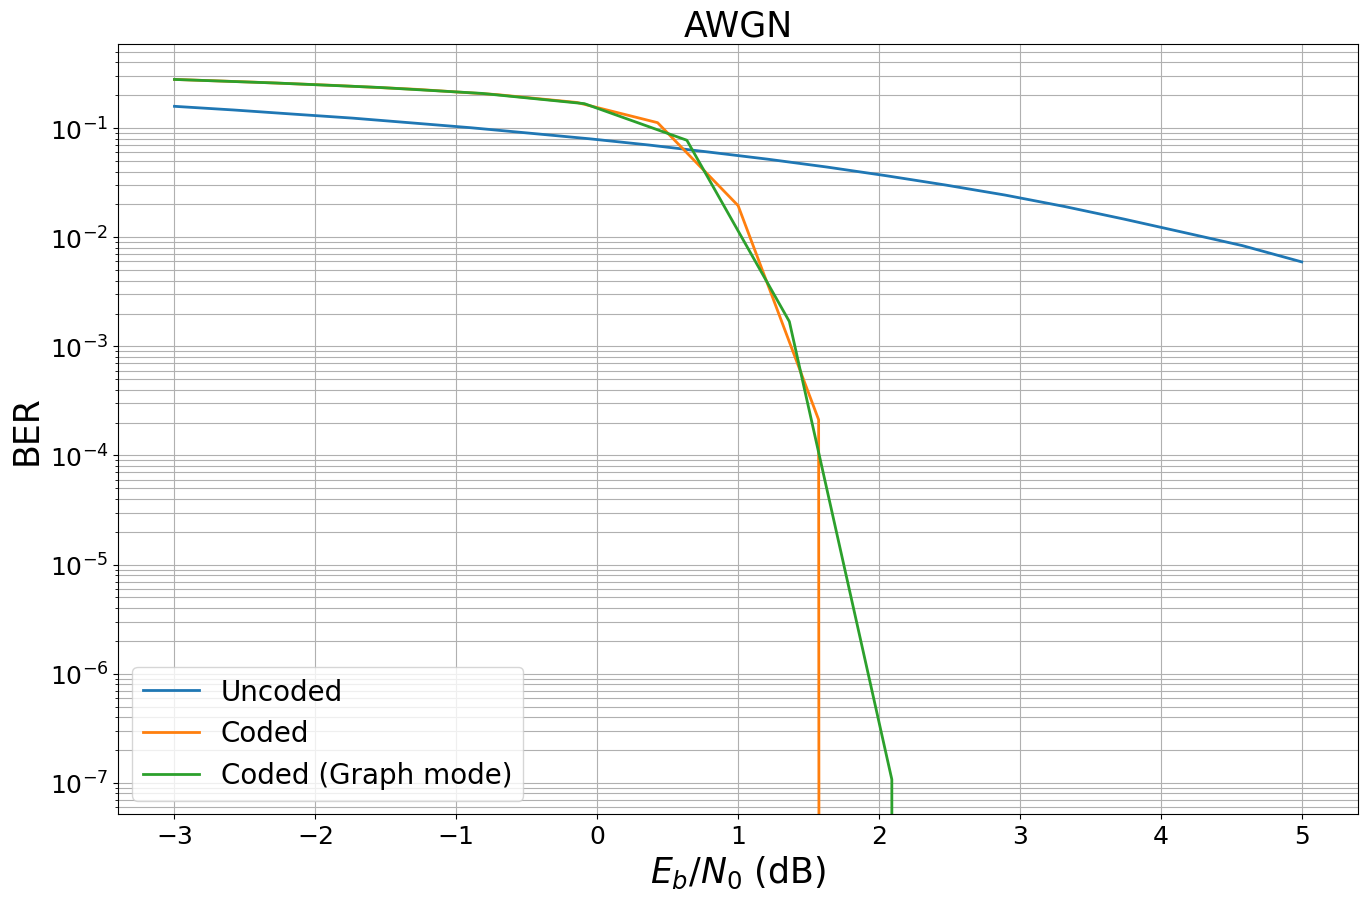

In [25]:
ber_plots.simulate(run_graph,
                   ebno_dbs=np.linspace(EBN0_DB_MIN, EBN0_DB_MAX, 12),
                   batch_size=BATCH_SIZE,
                   num_target_block_errors=500,
                   legend="Coded (Graph mode)",
                   soft_estimates=True,
                   max_mc_iter=100,
                   show_fig=True,
                   forward_keyboard_interrupt=False);

**Task:** TensorFlow allows to *compile* graphs with [XLA](https://www.tensorflow.org/xla). Try to further accelerate the code with XLA (`@tf.function(jit_compile=True)`).

*Remark*: XLA is still an experimental feature and not all TensorFlow (and, thus, Sionna) functions support XLA.

**Task 2:** Check the GPU load with `!nvidia-smi`. Find the best tradeoff between batch-size and throughput for your specific GPU architecture.

## Exercise

Simulate the coded bit error rate (BER) for a Polar coded and 64-QAM modulation.
Assume a codeword length of n = 200 and coderate = 0.5.

**Hint**: For Polar codes, successive cancellation list decoding (SCL) gives the best BER performance.
However, successive cancellation (SC) decoding (without a list) is less complex.



In [26]:
n = 200
coderate = 0.5

# *You can implement your code here*
